# Modelling

Este notebook é dedicado exclusivamente a parte de modelagem e avaliação dos respectivos modelos testados. No final deste arquivo encontra-se a previsão do preço para novos dados de entrada e também o processo de exportação do modelo já definido em um arquivo .pkl conforme solicitado pelo desafio.

## Entendendo o problema

Antes de inicar o desenvolvimento, primeiro é preciso entender de que tipo de problema de machine learning estamos falando. Como a ideia aqui é prever preços de aluguel, ou seja, um NÚMERO, um valor contínuo, portanto se trata de um problema de REGRESSÃO. Caso a ideia fosse prever alguma categoria, ou grupo, sendo este um dado discreto, ai sim estaríamos falando de um problema de classificação.

Além disso, sabe-se que se trata de um modelo SUPERVISIONADO, ou seja, nós temos descriminados em nosso dataset de treino e teste a variável que se deseja prever ('price'). Tem-se um amostral deste "target". Se por um acaso o "target" não estivesse descriminado ou definido, forçando com que o algoritmo tivesse que extrair um padrão de todo o amostral X, então se trataria de um modelo NÃO SUPERVISIONADO. Ai entrariam modelos de clusterização, recomendação e assim por diante.

Entendido isso, pode-se então partir para o desenvolvimento utilizando algoritmos e estratégias para resolver um problema de regressão.

## Importando as bibliotecas

Para iniciar o desenvolvimento, primeiro importou-se as bibliotecas que serão utilizadas nesta etapa de modelling,

In [65]:
# lib para salvar no formato .pkl
import pickle

# lib de manipulação dos dados
import pandas as pd
import numpy as np

# lib de visualização de dados nulos
import missingno as msno

# lib de visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# pré-processamento de dados
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

# separação das colunas por tipo de dado
from sklearn.compose import make_column_selector

# pipeline para tratamento dos dados
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# modelos de Regressão a serem testados
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# manter a saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output = 'pandas')

## Definindo as métricas de avaliação para os modelos de regressão a serem testados

Quando se fala em modelos de regressão, existem algumas métricas importantes para estas avaliações. Segue abaixo uma breve análise de 4 das mais importantes e famosas neste tipo de problema.

- R² = também chamado de coeficiente de determinação, é uma métrica que expressa a porcentagem da variância dos dados que pode ser explicada pelo modelo. É uma métrica que varia de 0 até 1, sendo quanto mais próximo de 1 maior a capacidade do modelo em explicar as variações dos dados.
- MAE = erro médio absoluto, basicamente mede a distância média entre os valores previstos pelo modelo e os valores reais. Outro ponto de destaque é que a unidade deste erro é a mesma do 'target', ou seja, tem a mesma unidade da variável preço. Contudo, esta métrica é muito sensível a outliers, desta forma, a tendência é "puxar" o modelo mais próximo dos outliers, deixando-o mais distante da maior concentração dos dados reais. Conforme foi visto nas análises feitas no notebook EDA, este dataset tem forte presença de outliers, portanto o MAE não seria o ideal para avaliar os modelos.
- MSE = erro médio quadrático, basicamente é a diferença entre o valor previsto e o valor real, elevando-se o resultado ao quadrado. Da mesma forma que o MAE, quanto maior esta métrica pior será o modelo. Como neste caso os erros são elevados ao quadrado, isto torna esta métrica muito boa para casos em que grande erros não são tolerados, deixando-a muito menos sensível a outliers, se comparada ao MAE.
- RMSE = raiz do erro quadrático médio, basicamente é a métrica MSE tirando a sua raiz quadrada. Desta forma, tem-se um valor de melhor interpretabilidade, corringindo também as unidades deste erro.

Considerando as características expostas acima e também as características dos dados deste dataset, expostas no notebook 'EDA.ipynb', optou-se por avaliar os modelos testados utilizando as métricas MSE e RMSE, visto que trabalham melhor em casos de outlier, sendo menos tolerantes com erros muito grandes. Além disso optou-se por expor junto a métrica R² por conta da sua fácil interpretabilidade.

Escolhidas as métricas utilizadas para a avaliação dos modelos, optou-se  por definir a função abaixo, que será chamada todas as vezes que for necessário calcular as métricas de algum modelo, a fim de deixar o código posteriormente mais "limpo".

In [2]:
# função para calcular as métricas dos modelos
def get_metrics (y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MSE': metrics.mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    }
    return dict_metrics

## Importando o dataset

Definidas as métricas, agora importou-se o dataset original disponibilizado, conforme segue.

In [3]:
df = pd.read_csv('../dataset/teste_indicium_precificacao.csv')
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


Exibindo mais informações do dataset,

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

## Dividindo as features do target

Primeiro de tudo, é preciso separar as variáveis que são features da variável "objetivo" ou target. O grupo das features que é composto por todas as variáveis que ajudam a explicar o comportamento do "target", restando para o outro grupo justamente a variável "target" que é o a coluna 'price' com o preço de aluguel dos imóveis.

Importante destacar aqui que, para o grupo das features, não serão utilizadas todas as colunas do dataset. De início, serão retiradas as colunas "id", "nome", "host_id" e "host_name", visto que elas retornam informações que não são relevantes para a determinação do preço dos aluguéis, pois somente dizem respeito a códigos de identificação e nome dos anúncios, não tem nada sobre os imóveis em si. 

In [5]:
# definindo o grupo das features
X = df.drop(columns = ['id', 'nome', 'host_id', 'host_name', 'price'])

# target
y = df['price']

## Separando as bases de treino e teste

Agora, é necessário separar os grupos definidos acima em duas bases, uma base de treino que será utilizado para treinar o modelo a ser definido e a base de teste será utilizada para avaliar a performance do modelo, comparando os resultados previstos com os resultados reais da base.

In [20]:
# separando as bases de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Visualizando os data frames das features de treino e teste,

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39115 entries, 26558 to 11167
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bairro_group                   39115 non-null  object 
 1   bairro                         39115 non-null  object 
 2   latitude                       39115 non-null  float64
 3   longitude                      39115 non-null  float64
 4   room_type                      39115 non-null  object 
 5   minimo_noites                  39115 non-null  int64  
 6   numero_de_reviews              39115 non-null  int64  
 7   ultima_review                  31068 non-null  object 
 8   reviews_por_mes                31068 non-null  float64
 9   calculado_host_listings_count  39115 non-null  int64  
 10  disponibilidade_365            39115 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [22]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9779 entries, 35697 to 36248
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bairro_group                   9779 non-null   object 
 1   bairro                         9779 non-null   object 
 2   latitude                       9779 non-null   float64
 3   longitude                      9779 non-null   float64
 4   room_type                      9779 non-null   object 
 5   minimo_noites                  9779 non-null   int64  
 6   numero_de_reviews              9779 non-null   int64  
 7   ultima_review                  7774 non-null   object 
 8   reviews_por_mes                7774 non-null   float64
 9   calculado_host_listings_count  9779 non-null   int64  
 10  disponibilidade_365            9779 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 916.8+ KB


## Separando as features numéricas das categóricas

Seguindo com o desenvolvimento do modelo, é preciso separar as features categóricas das features com dados numéricos. Isto se torna importante pois, dependendo do tipo de dado de cada coluna, o pré-processamento será diferente.

Para isso, utilizou-se da função make_column_selector da biblioteca sklearn importada anteriormente, de tal modo que esta função irá produzir listas somente com as colunas que tem o tipo de dado especificado em seu argumento.

In [23]:
# Seperando as colunas numéricas das categóricas
numerical_columns_selector = make_column_selector(dtype_exclude = object)
categorical_columns_selector = make_column_selector(dtype_include = object)

In [24]:
# grupo das features numéricas
numerical_features = numerical_columns_selector(X_train)
numerical_features

['latitude',
 'longitude',
 'minimo_noites',
 'numero_de_reviews',
 'reviews_por_mes',
 'calculado_host_listings_count',
 'disponibilidade_365']

In [25]:
# grupo das features categóricas
categorical_features = categorical_columns_selector(X_train)
categorical_features

['bairro_group', 'bairro', 'room_type', 'ultima_review']

## Pré-processamento dos dados nulos

Antes de partir para a construção do pipeline e demais pré-processamento dos dados, é preciso definir uma estratégia de tratamento dos dados nulos presentes neste dataset.

Assim, relembrando-se o dataset de treino,

In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39115 entries, 26558 to 11167
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   bairro_group                   39115 non-null  object 
 1   bairro                         39115 non-null  object 
 2   latitude                       39115 non-null  float64
 3   longitude                      39115 non-null  float64
 4   room_type                      39115 non-null  object 
 5   minimo_noites                  39115 non-null  int64  
 6   numero_de_reviews              39115 non-null  int64  
 7   ultima_review                  31068 non-null  object 
 8   reviews_por_mes                31068 non-null  float64
 9   calculado_host_listings_count  39115 non-null  int64  
 10  disponibilidade_365            39115 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


Utilizando da mesma linha de código do notebook 'EDA.ipynb', exibi-se a tabela abaixo com as infos dos dados nulos,

In [27]:
# definindo um data frame com a quantidade de dados nulos por coluna
missing_data = (
    X_train.isnull()
    .sum()
    .to_frame('missing_count')
)

# adicionando ao data frame uma coluna com a quantidade de dados nulos por coluna divido pela quantidade total de dados
missing_data = missing_data.join(((X_train.isnull().sum())/(X_train.shape[0])).to_frame('missing_pct'))

# formando a coluna 'missing_pct' para exibir os resultados com duas casas decimais e no formato de porcentagem
missing_data.style.format('{:.2%}', subset = 'missing_pct')

,missing_count,missing_pct
bairro_group,0,0.00%
bairro,0,0.00%
latitude,0,0.00%
longitude,0,0.00%
room_type,0,0.00%
minimo_noites,0,0.00%
numero_de_reviews,0,0.00%
ultima_review,8047,20.57%
reviews_por_mes,8047,20.57%
calculado_host_listings_count,0,0.00%


É interssante analisar que para as duas colunas "ultima_review" e "reviews_por_mes", tem-se exatamente a mesma quantidade de dados nulos, fato este que pode indicar uma correlação entre elas (quando uma for nula, a outra também será).

Para validar isto de forma mais clara, utilizou-se da biblioteca missingno importada anteriormente. Ela permite a plotagem de gráficos com destaque para os dados nulos, conforme demonstrado na linha de código abaixo.

<Figure size 1200x800 with 0 Axes>

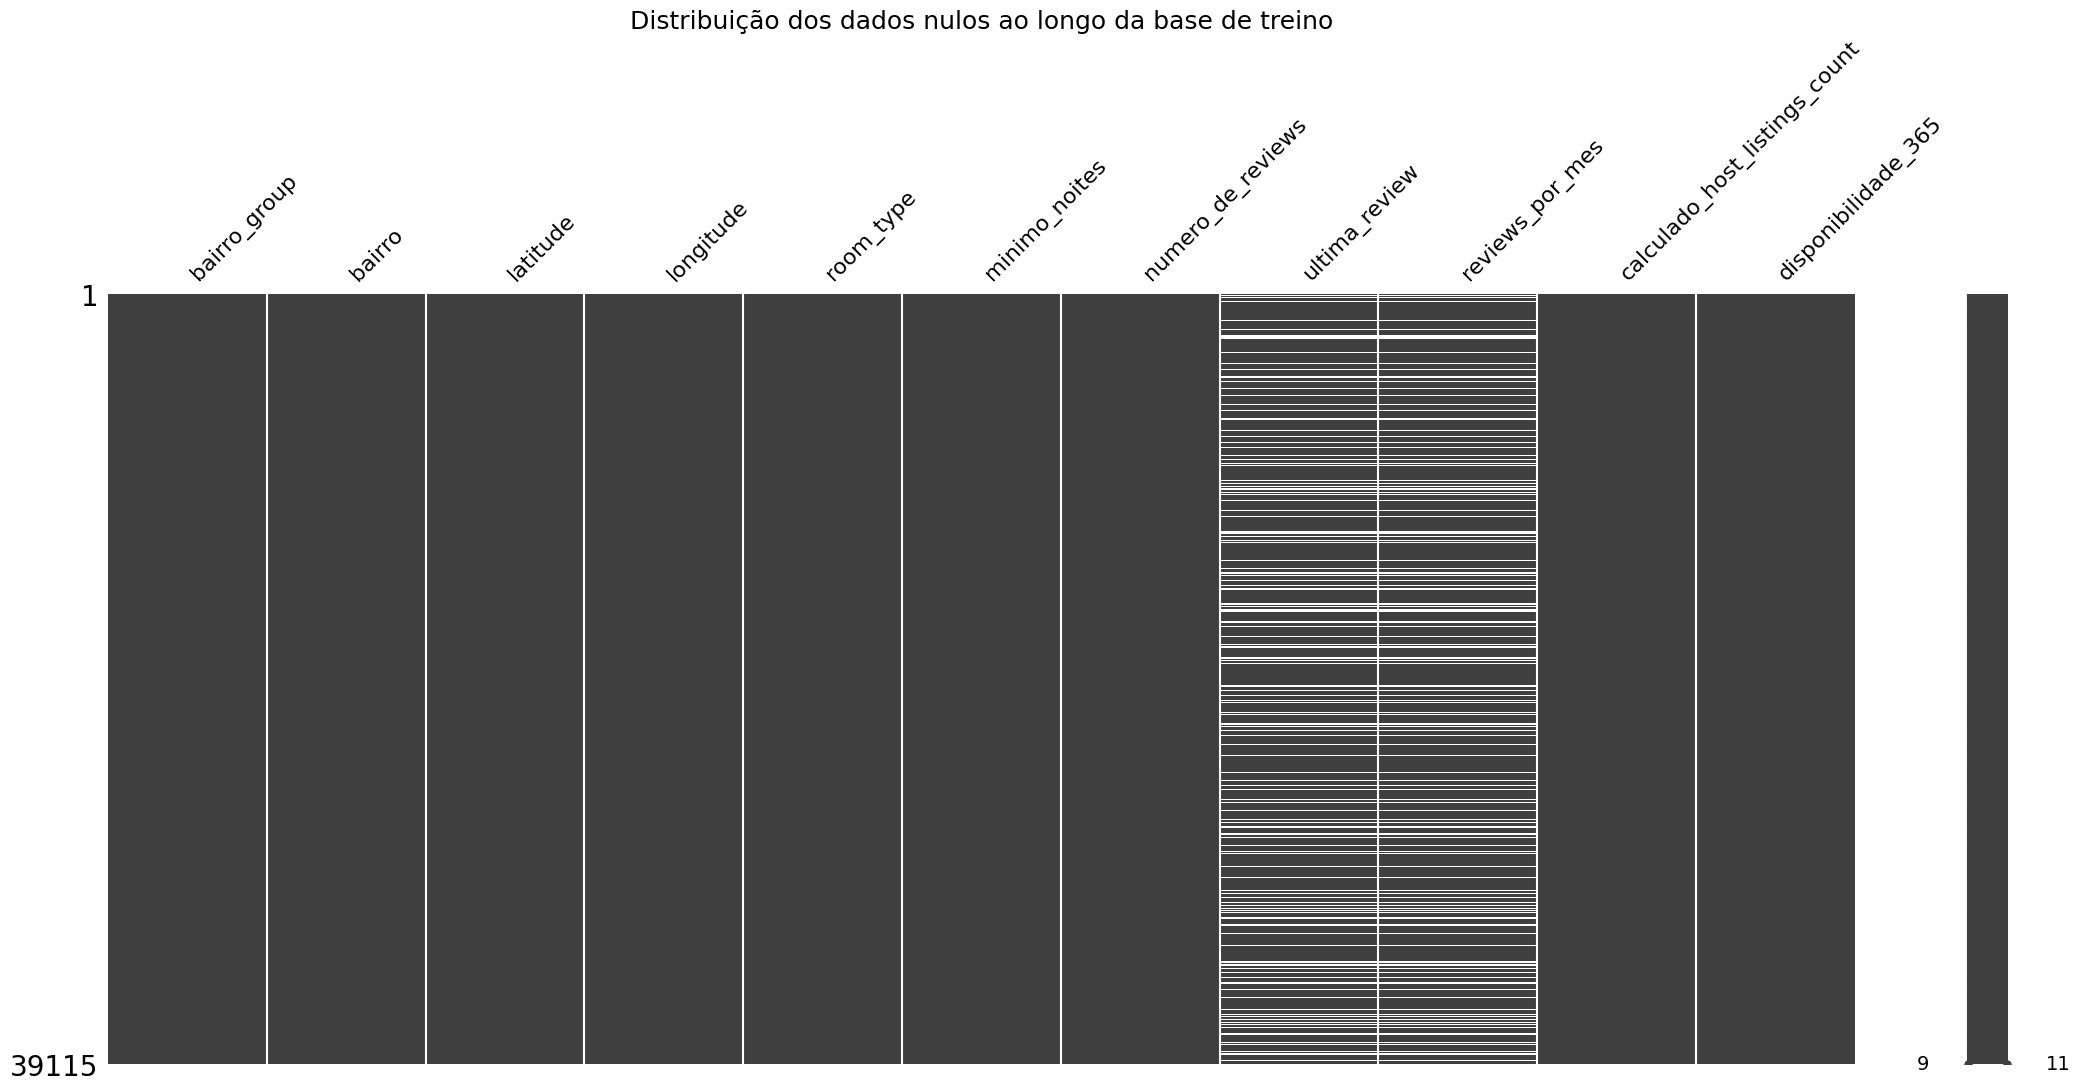

In [28]:
# definir tamanho da imagem
plt.figure(figsize = (12,8))

# plotando o gráfico
msno.matrix(df = X_train)

# título do gráfico
plt.title('Distribuição dos dados nulos ao longo da base de treino', fontsize = 18);

Observa-se na imagem acima um padrão claro: quando o dado presente na coluna "ultima_review" for nulo, o "reviews_por_mes" também será nulo. Isto faz sentido também se analisarmos do ponto de vista do negócio em si, pois se a coluna "ultima_review", que são datas, está nulo, quer dizer que provavelmente aquele imóvel nunca recebeu hóspedes, garantindo assim que não existirá nenhum review, pois o imóvel nunca foi avaliado.

Para confirmar isto, pode-se verificar quais são os dados presente na coluna "numero_de_reviews" nos casos em que "ultima_review" e "reviews_por_mes" forem nulos.

In [29]:
# filtrando todas as linhas do dataset de treino com dados nulos
X_train[X_train.isnull().any(axis = 1)]

,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
26558,Brooklyn,Clinton Hill,40.68729,-73.96785,Private room,14,0,NaN,NaN,1,0
24792,Manhattan,East Harlem,40.79405,-73.94242,Private room,7,0,NaN,NaN,1,0
48850,Queens,Woodhaven,40.69137,-73.86591,Private room,1,0,NaN,NaN,8,341
41130,Manhattan,Upper West Side,40.79901,-73.96135,Private room,30,0,NaN,NaN,32,317
30632,Brooklyn,Greenpoint,40.72407,-73.94762,Private room,1,0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...
16265,Manhattan,Chelsea,40.74451,-73.99236,Entire home/apt,30,0,NaN,NaN,87,350
32835,Brooklyn,Boerum Hill,40.68716,-73.98801,Entire home/apt,2,0,NaN,NaN,1,23
44069,Manhattan,Kips Bay,40.73859,-73.98218,Entire home/apt,360,0,NaN,NaN,4,364
46998,Manhattan,Chelsea,40.74441,-74.00765,Entire home/apt,2,0,NaN,NaN,1,74


In [30]:
# exibindo somente os dados da coluna 'numero_de_reviews'
X_train[X_train.isnull().any(axis = 1)]['numero_de_reviews'].value_counts()

numero_de_reviews
0    8047
Name: count, dtype: int64

Com este resultado acima, concluí-se exatamente o esperado: todas as linhas que apresentam dados nulos nas colunas "ultima_review" e "reviews_por_mes", tem número de reviews iguais a 0. Ou seja, de fato estes imóveis nunca foram alugados para hóspedes.

Logo, definiu-se duas estratégias diferentes para tratar estes dados nulos:
- "ultima_review": para esta coluna, os dados nulos serão substituídos por uma string "-" (esta string foi escolhida somente para demonstrar que aquele imóvel não tem review, poderia substituir por qualquer outra string aleatória). Importante: é obrigatório substituí-los por uma string pois esta coluna está com dados do tipo "object", então se torna necessário manter o mesmo tipo de dado já existente para posterior pré-processamento;
- "reviews_por_mes": para esta coluna, os dados nulos serão substituídos pelo número 0, indicando que não houve nenhum review pois o imóvel em questão nunca foi alugado. Da mesma forma que o caso anterior, substitui-se por um número pois os dados presentes nesta coluna são numéricos.

OBS: estas substituições serão feitas nas sessões a seguir, utilizando a função SimpleImputer da biblioteca sklearn.

## Pré-processamento de outliers

In [83]:
df.drop(columns = ['id', 'host_id']).describe(percentiles=[.75])

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
50%,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [84]:
X_train.describe(percentiles=[.99])

,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,39115.000000,39115.000000,39115.000000,39115.000000,31068.000000,39115.000000,39115.000000
mean,40.728926,-73.952219,7.039934,23.261946,1.369218,7.091781,112.414828
std,0.054507,0.045929,20.515274,44.610587,1.681917,32.791116,131.572346
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000
50%,40.723140,-73.955620,3.000000,5.000000,0.710000,1.000000,44.000000
99%,40.864569,-73.778213,45.000000,211.860000,7.183300,232.000000,365.000000
max,40.912340,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000


In [85]:
# função para tratamento dos outliers
def cap_values(array, lower_quantile=0.25, upper_quantile=0.75):
    array = array.copy()

    lower_quantile = np.quantile(array, lower_quantile)
    upper_quantile = np.quantile(array, upper_quantile)

    array[array<lower_quantile] = lower_quantile
    array[array>upper_quantile] = upper_quantile

    return array

## Definindo o pré-processamento dos dados para o modelo linear

Traçada a estratégia para tratamento dos dados nulos, e já separadas as colunas categóricas e numéricas das features, agora é possível definir toda a estrutura de pré-processamento dos dados.

Para problemas de regressão, tem-se basicamente 3 tipos de modelos diferentes (lineares, árvore de descisão e ensemble models). 

- Modelos lineares : conforme visto anteriormente nas análises feitas no EDA, nenhuma feature apresentou correlação linear com a nossa variável target 'price'. Além disso, caso fosse do interesse utilizar um modelo linear, seria necessário aplicar dois pré-processadores:
    - StandardScaler: usado nas features numéricas, ele funciona de forma a transformar todos os dados numéricos de uma coluna em uma distribuição de tal modo que a média tende a 0 e o desvio padrão fica muito próximo de 1. Este transformador é para modelos lineares pois neste tipo de abordagem, a ordem de grandeza dos números interfere no algoritmo do modelo, e como tem-se colunas numéricas das mais variadas escalas, padronizá-los ajuda a converter em um resultado de forma mais rápida e precisa.
    - OneHotEncoder: usado nas features categóricas, este transformador converte todas as entradas diferentes de uma coluna categórica em uma nova coluna, de tal forma que estas novas colunas serão preenchidas por 0, caso aquela característica não exista naquela coluna, ou 1 caso exista. O problema é que existem duas colunas categóricas na base de treino, "ultima_review" e "bairro", que apresentam muitas entradas diferentes, o que levaria a serem criadas uma quantidade exagerada de novas colunas. Isto irá fazer com que os cálculos deste modelo fiquem muito devagar, além de exigir um processamento demasiadamente desnecessário da máquina que irá executar o código.

- Árvore de descisão: diferentemente dos modelos lineares, não é extremamente necessário tratar as features numéricas, visto que a ordem de grandeza dos números não interfere nos cálculos realizados por este tipo de algoritmo. Isto também implica em poder utilizar-se de outro pré-processador nas features categóricas:
    - OrdinalEncoder: usado nas features categóricas, este pré-processador basicamente irá substituir as diferentes entradas das colunas por um número aletório. Diferentemente do OneHotEncoder, não serão criadas nenhuma nova coluna, apenas substituirá as entradas do tipo texto por números. Como a ordem de grandeza não interfere, pouco importa por qual número será substituído o texto, desde que dois textos diferentes se transformem em dois números diferentes.

- Ensemble models: funciona com basicamente os mesmo pré-processadores dos modelos de árvore de descisão, contudo geralmente apresentam metodologias de cálculos e seleção que propiciam resultados mais vantajosos que os demais tipos de modelos.

Feitas essas análises, foi definido testar apenas modelos de árvore de descisão e ensemble models, visto que os modelos lineares exigiram um pré-processamento maior com resultados nem tão satisfatórios.

Assim, foram definidos o pré-processamento das features numéricas de tal forma a tratar os dados nulos. Para as categóricas, tratou-se os dados nulos com posterior transformação usando o OrdinalEncoder. E por fim, define-se o "preprocessor" englobando tudo, atribuindo cada transformador as respectivas features corretamente.

In [76]:
# pré-processamento das features numéricas
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
    ('scaler', FunctionTransformer(func = cap_values))
])

# definindo o OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

# pré-processamento das features categóricas
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = '-')),
    ('encoder', encoder)
])

# pré-processamento completo, aplicando os transformadores as suas respectivas colunas
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features),
])

## Criando o pipeline completo

Agora, basta adicionar um estimador para termos o pipeline completo. Para fins de avaliação dos modelos testados, será treinado e testado junto um "baseline" chamado DummyRegressor. A função deste "baseline" é basicamente "chutar" todos os preços de alugel como sendo a média de preço dos imóveis da base de treino. Ele será usado como referência de análise, visto que um modelo de machine learning robusto deve no mínimo ter melhor performance do que um "chute" igual para todos os cenários.

In [77]:
# Criando o modelo em pipeline
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

No exemplo acima, definiu-se o estimador, chamado "model", do pipeline como sendo o DummyRegressor. Contudo, para serem testados vários modelos de uma só vez, optou-se por utilizar-se uma ferramenta chamada GridSearchCV, da biblioteca sklearn.

Para isso, primeiro foram definidos os parâmetros a serem testados, que neste caso são todos os modelos, conforme descrito no dicionário exposto no código abaixo.

In [78]:
# parâmetros
params = {
    'model':[
        DummyRegressor(),
        RandomForestRegressor(),
        GradientBoostingRegressor(),
        HistGradientBoostingRegressor()
    ]
}

Definindo-se agora o GridSearch, para que os parâmetros acima rodem dentro do pipeline definido anteriormente,

In [70]:
# Utlizando o GridSearch dentro do pipeline para testar vários modelos de uma só vez
grid_model = GridSearchCV(estimator = model_pipeline, param_grid = params, cv = 5, scoring = 'r2', verbose = 1)

Feito isso, agora o modelo com grid search será treinado com a base de treino definida anteriormente.

In [71]:
grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant')),
                                                                                         ('scaler',
                                                                                          FunctionTransformer(func=<function cap_values at 0x000001D1CA4F1B20>))]),
                                                                         ['latitude',
                                                                          'longitude',
                                                                          'minimo_noites',
                                                                          'numero_de_reviews',
                                                                          'reviews_por_mes',
                                                                          'calculado_host_l...
                                                                                          SimpleImputer(fill_value='nao '
                                                                                                                   'teve',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['bairro_group',
                                                                          'bairro',
                                                                          'room_type',
                                                                          'ultima_review'])])),
                                       ('model', DummyRegressor())]),
             param_grid={'model': [DummyRegressor(), RandomForestRegressor(),
                                   GradientBoostingRegressor(),
                                   HistGradientBoostingRegressor()]},
             scoring='r2', verbose=1)

Conferindo agora os resultados do GridSearch,

In [72]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:,~df_cv_results.columns.str.contains('split|time')]

,param_model,params,mean_test_score,std_test_score
rank_test_score,,,,
1,HistGradientBoostingRegressor(),{'model': HistGradientBoostingRegressor()},0.180023,0.043926
2,RandomForestRegressor(),{'model': RandomForestRegressor()},0.128636,0.060987
3,GradientBoostingRegressor(),{'model': GradientBoostingRegressor()},0.125047,0.069642
4,DummyRegressor(),{'model': DummyRegressor()},-0.000062,0.000035
